In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')
with open('/srv/scratch/z5297792/Clim_data/Sample_Data/dic_sample_vert_info.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = [8, 896, 2504, 2749, 382, 926, 1394, 1967]

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth

Rc_max = 20

In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


In [3]:
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])


In [5]:
for eddy in [sample_eddies[0], sample_eddies[4]]:
    eddy = f'Eddy{eddy}'
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        df = dic[day]

        if len(df):

            Qs = df['Q'].values.copy()
            Rcs = df['Rc'].values.copy()
            psi0s = df['psi0'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            
            # smooth against frame index t
            window = 50
            sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=window)
            sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=window)
            sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=window)
    
            df['sw'] = 2 * (sq11 + sq22)
            df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
            
            mask = Rcs > Rc_max
            Rcs[mask] = np.nan
            psi0s[mask] = np.nan
            df['sRc']   = smooth(Rcs,                    depths, window=window)
            df['spsi0'] = smooth(psi0s,                  depths, window=window)
            

/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-pac

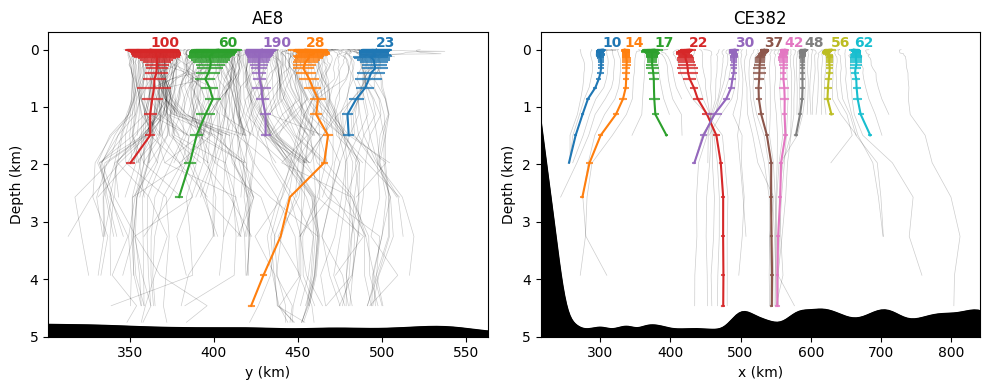

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

eddy_p = [sample_eddies[0], sample_eddies[4]]

days_p = [[23, 28, 60, 100, 190],
          [10, 14, 17, 22, 30, 37, 42, 48, 56, 62]]
          
for e, (eddy, days) in enumerate(zip(eddy_p, days_p)):

    ax = axs[e]

    eddy = f'Eddy{eddy}'
    
    pmean = df_means[df_means['Eddy']==eddy].iloc[0]
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        if int(day[3:]) not in days:
            df = dic[day].copy()
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
            else:
                ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
    
    colors = plt.get_cmap('tab10').colors
    for d, day_idx in enumerate(days):
        
        day_key = list(dic_sample[eddy].keys())[day_idx]
        df = dic[day_key].copy()
    
        if len(df):
            
            # raw data
            xs = df['x'].values.copy()
            ys = df['y'].values.copy()
            sQs = df['sQ'].values.copy()
            sq11 = [q[0,0] for q in sQs]
            sq12 = [q[0,1] for q in sQs]
            sq22 = [q[1,1] for q in sQs]
            sRc = df['sRc'].values.copy()
            spsi0 = df['spsi0'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            
            # plot each smoothed ellipse at its depth
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(xs, depths, color=colors[d % 10], label=day_idx)
                ax.text(xs[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            else:
                ax.plot(ys, depths, color=colors[d % 10], label=day_idx)
                ax.text(ys[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            for x0, y0, q11, q12, q22, Rc, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, depths):
                Qm = np.array([[q11, q12],[q12, q22]])
                xe, ye = plot_ellipse(Qm, (x0, y0), scale=Rc)
                ze = np.full_like(xe, z0)
                if ('1967' in eddy) or ('382' in eddy):
                    ax.plot(xe, ze, color=colors[d % 10], alpha=0.8)
                else:
                    ax.plot(ye, ze, color=colors[d % 10], alpha=0.8)

    xlim = ax.get_xlim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean']-y_grid)==np.min(np.abs(pmean['y_mean']-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', )
    else:
        ic = np.where(np.abs(pmean['x_mean']-x_grid)==np.min(np.abs(pmean['x_mean']-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k')
    
    ylim = ax.get_ylim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean'] - y_grid) == np.min(np.abs(pmean['y_mean'] - y_grid)))[0][0]
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k')
    else:
        ic = np.where(np.abs(pmean['x_mean'] - x_grid) == np.min(np.abs(pmean['x_mean'] - x_grid)))[0][0]
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if ('1967' in eddy) or ('382' in eddy):
        ax.set_xlabel('x (km)')
    else:
        ax.set_xlabel('y (km)')
    
    ax.set_ylabel('Depth (km)')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')
    # ax.legend(title='Day', loc='lower right', ncol=2)
    
axs[0].invert_yaxis()
axs[0].set_ylim(5, -.3)
axs[1].invert_yaxis()
axs[1].set_ylim(5, -.3)
    
plt.tight_layout()
plt.show()


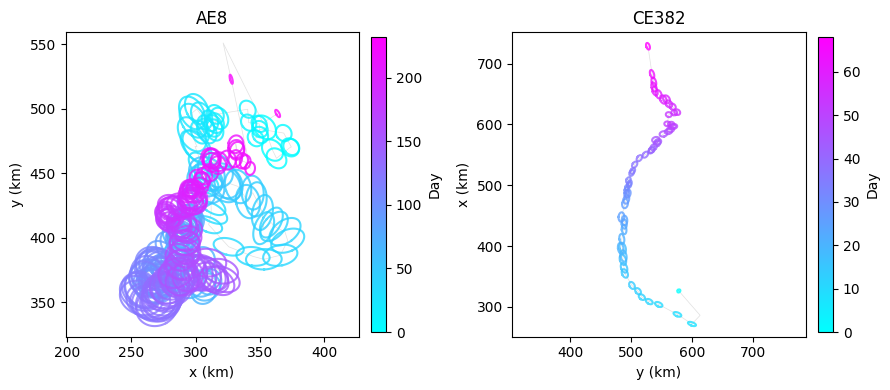

In [54]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 2, figsize=(9,4))#, gridspec_kw={'width_ratios': [1, 2]})

for e, eddy in enumerate(eddy_p):
    ax = axs[e]
    eddy = f'Eddy{eddy}'
    xs, ys, Qs, Rcs, ds = [], [], [], [], []
    for d, day in enumerate(dic_sample[eddy]):
        df = dic_sample[eddy][day]
        if df.empty:
            continue
        xs.append(df.iloc[0]['x'])
        ys.append(df.iloc[0]['y'])

        Q = df.iloc[0]['sQ']
        if not np.any(np.isnan(Q)):
            Qs.append(np.array(Q))
        else:
            Qs.append(df.iloc[0]['Q'])
        
        Rc = df.iloc[0]['sRc']
        if not np.isnan(Rc):
            Rcs.append(Rc)
        else:
            Rcs.append(df.iloc[0]['Rc'])
            
        ds.append(d)

    if not ds:
        ax.set_title(eddy)
        continue

    if ('382' in eddy) or ('1967' in eddy):
        ax.plot(ys, xs, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('y (km)')
        ax.set_ylabel('x (km)')
    else:
        ax.plot(xs, ys, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')

    days = np.array(ds)
    window = 5
    sq11 = smooth([q[0,0] for q in Qs], days, num=len(days), window=window)
    sq12 = smooth([q[0,1] for q in Qs], days, num=len(days), window=window)
    sq22 = smooth([q[1,1] for q in Qs], days, num=len(days), window=window)

    Rcs = np.array(Rcs)
    Rcs[Rcs > Rc_max] = np.nan
    sRc  = smooth(Rcs,       days, num=len(days), window=window)

    norm = Normalize(vmin=days.min(), vmax=days.max())
    cmap = cool
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(days)

    for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sRc, ds):
        Qm = np.array([[a, b], [b, c]])
        xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
        if ('382' in eddy) or ('1967' in eddy):
            ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)
        else:
            ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)

    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.04
    )
    cbar.set_label('Day')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')

    ax.axis('equal')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')

plt.tight_layout()
plt.show()


#### Horizontal Velocity vector plots

In [18]:
fnumber_old = 0

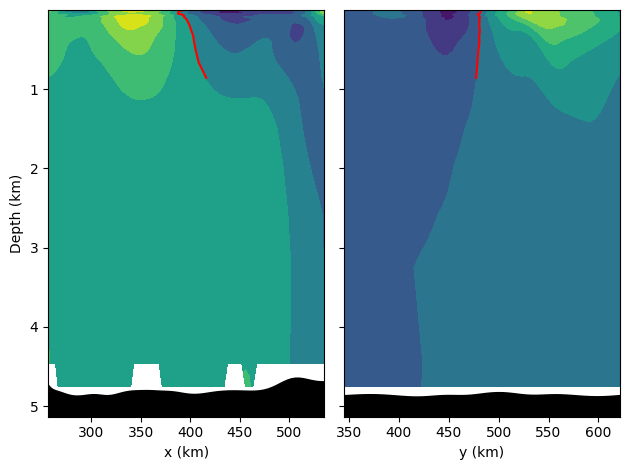

In [57]:
eddy = 382
day_idx = 20
r = 140

dic = dic_sample[f'Eddy{eddy}']
day = list(dic.keys())[day_idx]
df = dic[day].copy()
day = int(day[3:])

fname = df_eddies[(df_eddies['ID']==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']

fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(x_grid[x_mask], -z_r/1000, v_t[x_mask, jc, :].T)
axs[0].plot(df.x, -df.Depth/1000, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].invert_yaxis()
axs[1].contourf(y_grid[y_mask], -z_r/1000, u_t[ic, y_mask, :].T)
axs[1].plot(df.y, -df.Depth/1000, color='r')
axs[1].set_xlabel('y (km)')

axs[0].plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
axs[1].plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
ylim0 = axs[0].get_ylim()
ylim1 = axs[1].get_ylim()
axs[0].fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
axs[1].fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
axs[0].set_ylim(ylim0)
axs[1].set_ylim(ylim1)

plt.tight_layout()


(np.float64(243.55938332824948),
 np.float64(531.6867937236777),
 np.float64(331.58039753625013),
 np.float64(630.2588775424608))

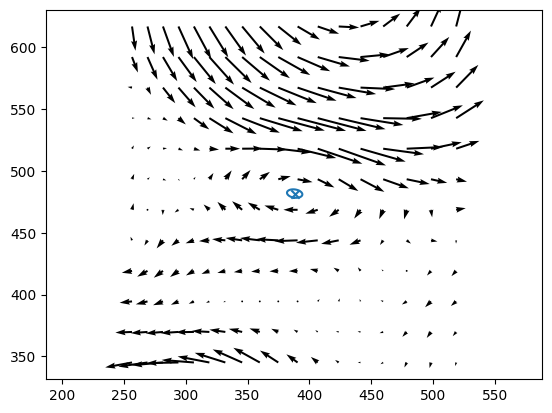

In [58]:
k = 5

Xp, Yp = np.meshgrid(x_grid[x_mask], y_grid[y_mask], indexing='ij')
up = u_t[np.ix_(x_mask, y_mask, [k])][:, :, 0]
vp = v_t[np.ix_(x_mask, y_mask, [k])][:, :, 0]
spac = 5
plt.quiver(Xp[::spac, ::spac], Yp[::spac, ::spac],
           up[::spac, ::spac], vp[::spac, ::spac])

data = df[df.z==k].iloc[0]
plt.scatter(data.x, data.y, marker='x')
x_ell, y_ell = plot_ellipse(data.Q, (data.x, data.y), scale=data.Rc)
plt.plot(x_ell, y_ell)
plt.axis('equal')
